In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [ ]:
# Define tickers for various asset classes
tickers = {
    'equities': ['AAPL', 'MSFT', 'JNJ'],
    'bonds': ['TLT'],
    'real_estate': ['VNQ'],
    'commodities': ['GLD', 'USO'],
    'cash': ['SHV']
}

In [ ]:
# Flatten the tickers list for download
all_tickers = [ticker for sublist in tickers.values() for ticker in sublist]

# Download historical data (adjusted close prices)
data = yf.download(all_tickers, start="2006-01-01", end="2010-01-01")['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

[*********************100%%**********************]  8 of 8 completed


In [ ]:
print(mean_returns)

Ticker
AAPL    0.001450
GLD     0.000883
JNJ     0.000156
MSFT    0.000346
SHV     0.000105
TLT     0.000241
USO     0.000220
VNQ     0.000140
dtype: float64


In [ ]:
print(cov_matrix)

Ticker      AAPL           GLD           JNJ      MSFT           SHV  \
Ticker                                                                 
AAPL    0.000791 -3.073783e-05  1.447649e-04  0.000358 -3.056196e-06   
GLD    -0.000031  2.409465e-04 -6.077648e-07  0.000011  2.193979e-07   
JNJ     0.000145 -6.077648e-07  1.764930e-04  0.000178 -1.322949e-06   
MSFT    0.000358  1.100291e-05  1.783165e-04  0.000569 -3.010917e-06   
SHV    -0.000003  2.193979e-07 -1.322949e-06 -0.000003  1.723126e-07   
TLT    -0.000087  3.715297e-06 -3.440341e-05 -0.000072  8.371648e-07   
USO     0.000216  1.380323e-04  7.945583e-05  0.000191 -1.685196e-06   
VNQ     0.000528 -3.846986e-06  2.451697e-04  0.000511 -3.067354e-06   

Ticker           TLT       USO       VNQ  
Ticker                                    
AAPL   -8.702842e-05  0.000216  0.000528  
GLD     3.715297e-06  0.000138 -0.000004  
JNJ    -3.440341e-05  0.000079  0.000245  
MSFT   -7.244773e-05  0.000191  0.000511  
SHV     8.371648e-07 

In [ ]:
#Define risk-free rate
risk_free_rate = 0.01

# Function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

# Objective function: maximize Sharpe Ratio
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

In [ ]:
# Constraints: sum of weights = 1
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Bounds for weights: between 0 and 1
bounds = tuple((0, 1) for _ in range(len(all_tickers)))

# Initial guess for weights
initial_weights = len(all_tickers) * [1. / len(all_tickers)]

# Optimize portfolio to maximize Sharpe Ratio
optimized_result = minimize(neg_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix, risk_free_rate),
                            method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = optimized_result.x
print(f"Optimal Weights: {optimal_weights}")


Optimal Weights: [7.47108946e-03 7.67446042e-03 2.09742685e-03 1.40708979e-03
 9.77031790e-01 4.31814359e-03 7.84296304e-13 1.94714229e-12]


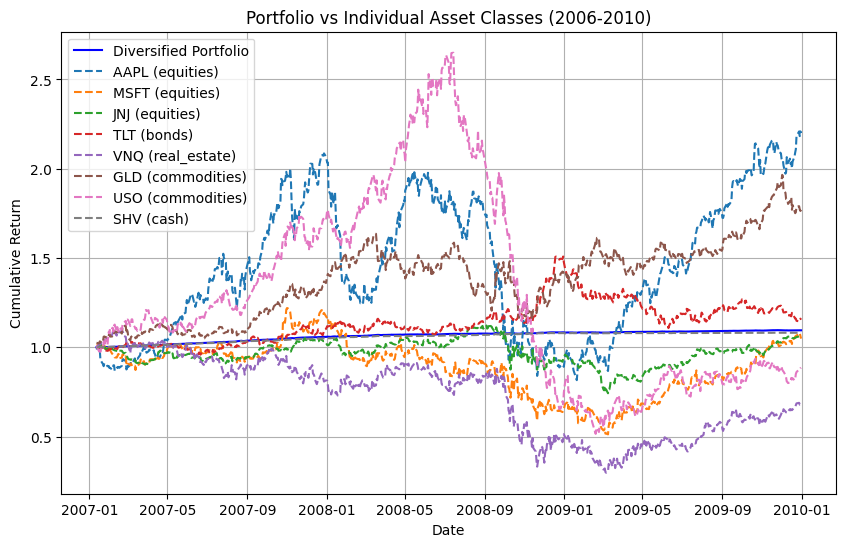

In [ ]:
# Calculate daily portfolio returns
portfolio_daily_returns = np.dot(returns, optimal_weights)

# Convert daily portfolio returns to a pandas Series
portfolio_returns_series = pd.Series(portfolio_daily_returns, index=returns.index)

# Calculate cumulative returns for the portfolio within the specified period
cumulative_returns = (1 + portfolio_returns_series).cumprod()

# Ensure cumulative returns only cover the period from 2006 to 2010
cumulative_returns = cumulative_returns.loc['2006-01-01':'2010-01-01']

# Plot cumulative returns for the portfolio and individual asset classes
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label='Diversified Portfolio', color='blue')

for asset_class, ticker_list in tickers.items():
    for ticker in ticker_list:
        ticker_cumulative_returns = (1 + returns[ticker]).cumprod()
        plt.plot(ticker_cumulative_returns, label=f'{ticker} ({asset_class})', linestyle='--')

plt.title('Portfolio vs Individual Asset Classes (2006-2010)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Analyze performance metrics for the portfolio
def calculate_performance_metrics(returns, risk_free_rate=0.01):
    annual_return = np.mean(returns) * 252
    annual_volatility = np.std(returns) * np.sqrt(252)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
    max_drawdown = np.min(returns)  # Adjust if you want a different drawdown calculation

    return annual_return, annual_volatility, sharpe_ratio, max_drawdown

annual_return, annual_volatility, sharpe_ratio, max_drawdown = calculate_performance_metrics(portfolio_returns_series)

print(f"Annual Return: {annual_return:.2f}")
print(f"Annual Volatility: {annual_volatility:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}")


Annual Return: 0.03
Annual Volatility: 0.01
Sharpe Ratio: 3.06
Max Drawdown: -0.00
